<center><h1><b>Project Module</b></h1></center>
<center><h2>**SPIDER: Scientific Publication Indexing and Definition Extraction Resource**</h2></center>


<div>

<ul style="float:left">
<span><b>Group Members</b></span>
<li>Pratik Nichite</li>
<li>Abdul Basit Raja</li>
<li>Pranav Kumar Sah</li>
<li>Priyanka Singh</li>
</ul>
<h4 style="float: right"><b>Project Supervisor</b></br> Prof. Dr. Ivan P. Yamshchikov</h4>
</div>

<h4>Importing all the required libraries and modules</h4>

In [140]:
import re
import os
import math # type: ignore
import PyPDF2 # type: ignore
import requests # type: ignore
import numpy as np # type: ignore
import pandas as pd # type: ignore
import matplotlib.pyplot as plt # type: ignore

from io import StringIO
from nltk import pos_tag # type: ignore
from collections import Counter
from nltk.stem import PorterStemmer # type: ignore
from transformers import AutoTokenizer # type: ignore
from nltk.tokenize import word_tokenize # type: ignore
from pdfminer.high_level import extract_text # type: ignore

In [240]:
# Constants

MODEL_PATH = r"C:\Users\harri\OneDrive\Desktop\Phi3\Phi-3-mini-128k-instruct"
REMOVAL_PERCENTAGE_VALUE = 0.90 # Percentage Value
GLOSSARY_CSV_FILE_PATH = r"C:\Users\harri\Downloads\glossary-statical-learning.csv"
OLLAMA_LOCAL_HOST = "http://localhost:11434/api/generate"

<h4>Converting .PDF file to .TXT</h4>

In [241]:
def pdf_to_text(pdf_path, text_path):
        with open(pdf_path, 'rb') as pdf_file:
            pdf_reader = PyPDF2.PdfReader(pdf_file)
            num_pages = len(pdf_reader.pages)

            os.makedirs(os.path.dirname(text_path), exist_ok=True)

            with open(text_path, 'w', encoding='utf-8') as text_file:
                for page_num in range(num_pages):
                    page = pdf_reader.pages[page_num]
                    text_file.write(page.extract_text())

        print(f"Conversion successful. PDF to TXT saved to location: {text_path}")

In [53]:
pdf_file_path = r'C:\Users\harri\Downloads\An Introduction to Statistical Learning.pdf' # Provide your .pdf file location
text_file_path = r'C:\Users\harri\Downloads\convertedpdftotxt.txt' # Provide your destination path for converted .txt file

pdf_to_text(pdf_file_path,text_file_path)

Conversion successful. PDF to TXT saved to location: C:\Users\harri\Downloads\convertedpdftotxt.txt


<h4>Reading the converted .TXT file</h4>

In [242]:
def read_txt_file(txt_path_location):
    with open(txt_path_location, 'r', encoding="utf8") as file:
        text = file.read()
    return text

<h4>Defining Tags</h4>

In [243]:
# NLTK has following tags for nouns
# NN: Noun, singular or mass
# NNS: Noun, plural
# NNP: Proper noun, singular
# NNPS: Proper noun, plural
tag_filter = ["NN", "NNS"]


def filter_tags(input_tag):
    token, tag = input_tag
    return tag in tag_filter # if the tag is in tags list, it will return True

<h4>Extracting Nouns</h4>

In [244]:
ps = PorterStemmer()

def extract_nouns(input_text):
    cleaned_text = re.sub('[^a-zA-Z]', ' ', input_text)

    # tokenize text
    tokenized_text = word_tokenize(cleaned_text) # nltk tokenizer
    
    # pos-tagging of stemmed text
    pos_tags = pos_tag(tokenized_text)
    
    # filter out non-Noun tags
    filtered_tags = list(filter(filter_tags, pos_tags))
    
    if len(filtered_tags) <= 0:
        return []

    tokens, tags = zip(*filtered_tags) #unpacking tokens and tags
    
    # lemmatization of text
    stemmed_tokens = list(map(ps.stem, tokens))

    return stemmed_tokens

<h4>Generating Tokens</h4>

In [246]:
def generate_token(text):
    tokens = []
    with open(text_file_path, 'r', encoding="utf8") as file:
        for line in file:
            temp_tokens = extract_nouns(input_text = line)
            tokens.extend(temp_tokens)

    return tokens    

<h4>Creating Dictonaries for Frequencies</h4>

In [247]:
def convert_to_dictionary(_token):
    _frequencies = Counter(_token)
    return pd.DataFrame({"Word":_frequencies.keys(), "Frequencies": _frequencies.values()})

In [248]:
def generate_frequencies(freq):
    df = pd.DataFrame(freq.items(), columns=['Token', 'Frequency'])
    df.to_csv("Nouns.csv", index=False)
    return df

<h4>Sorting Frequencies by value of frequency in Ascending order</h4>

In [249]:
def sort_frequencies_df(_df):
    return _df.sort_values(by = ["Frequency"])

<h4>Removing most unique data based on percentage value</h4>

In [250]:
def remove_percentage_from_data(_df):
    from_index = math.floor(len(_df) * REMOVAL_PERCENTAGE_VALUE)
    return _df.iloc[from_index:, :]
    

<h4>Plotting the Above Generated Frequencies</h4>

In [251]:
def plot_generated_frequencies(_frequencies):
    plt.figure(figsize=(10, 7))
    plt.plot(_frequencies.keys(), _frequencies.values())
    plt.ylabel('token frequencies')
    plt.xlabel('tokens')
    plt.xticks([])
    plt.title("Word Frequencies (Book)")
    plt.show()    

<h4>Using Phi3 Model for Tokenizing the text from Hugging Face</h4>

In [152]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


<h4>Tokenizing the data by the Phi3</h4>

In [252]:
def tokenize_data(df):
    
    data_tokenized = []
    nouns = df["Token"].values

    for noun in nouns:  
        tokens = tokenizer.tokenize(noun)

        num_tokens = len(tokens)
        word_length = len(noun)

        data_tokenized.append({"tokens": tokens, "num_tokens": num_tokens, "word_length": word_length})

    return data_tokenized

In [253]:
def calculate_ratio_num_token_for_word_length(_df):
    _df["ratio"] = _df["num_tokens"] / _df["word_length"]
    return _df

In [156]:
# Function for generating Normal Distribution
def normal_pdf(x, mu, sigma):
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-(x - mu)**2 / (2 * sigma**2))

In [157]:
def calculate_mean_sd_of_tokenized_data(_df):
    mean = _df['ratio'].mean()
    std = _df['ratio'].std()
    return mean, std

<h4>Plotting Graph to show Distribution</h4>

In [255]:
def plot_distribution(_df, mean, std):
    plt.figure(figsize=(10, 6)) 

    x = np.linspace(_df['ratio'].min(), _df['ratio'].max(), 1000)
    y = normal_pdf(x, mean, std)

    # normal distribution
    plt.plot(x, y, 'blue', lw=2) 

    #histogram
    plt.hist(_df["ratio"], bins=13, density=True, color="green", alpha=0.6, edgecolor='black')

 
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.title("Distribution of Tokens")
    plt.xlabel("Ratio (#Tokens / #Letters)")
    plt.ylabel("Population")

    plt.show()
    


In [256]:
def get_unique_terms_by_threshold_min_max_value(df, threshold_min, threshold_max):
    unique_terms = df.loc[df['ratio'] <= threshold_max].copy()
    unique_terms = unique_terms.loc[unique_terms['ratio'] > threshold_min]
    unique_terms.to_csv(f"{threshold_min-threshold_max}.csv")
    return unique_terms
    

In [257]:
df_glossary = pd.read_csv(GLOSSARY_CSV_FILE_PATH)
df_glossary

,words
0,activation
1,additive
2,additivity
3,alternative
4,hypothesis
...,...
753,weights
754,within
755,class
756,covariance


In [258]:
def extract_nouns_from_glossary(_df):
    glossary = _df["words"].dropna().values
    glossary_tk_spider = []

# tokenize with our process first
    for word in glossary:
        tokens = extract_nouns(word)
        if len(tokens) <= 0:
            continue
        
        glossary_tk_spider.extend(tokens)
    return glossary_tk_spider
    
    

In [259]:
glossary_tk_spider = extract_nouns_from_glossary(df_glossary)
print(glossary_tk_spider)

['activ', 'addit', 'altern', 'hypothesi', 'area', 'curv', 'array', 'auc', 'auto', 'correl', 'backfit', 'backward', 'stepwis', 'select', 'bag', 'word', 'baselin', 'classifi', 'decis', 'boundari', 'error', 'regress', 'tree', 'procedur', 'subset', 'select', 'bia', 'bia', 'varianc', 'trade', 'bikeshar', 'data', 'set', 'binari', 'method', 'boolean', 'bootstrap', 'bottom', 'braincanc', 'data', 'set', 'burn', 'caravan', 'data', 'set', 'carseat', 'data', 'set', 'data', 'left', 'time', 'chain', 'rule', 'cifar', 'data', 'set', 'classif', 'tree', 'classifi', 'bottom', 'mean', 'colleg', 'data', 'set', 'collinear', 'concaten', 'contour', 'contrast', 'convolut', 'layer', 'convolut', 'network', 'correl', 'cox', 'proport', 'hazard', 'model', 'cp', 'cross', 'entropi', 'cross', 'valid', 'data', 'set', 'auto', 'caravan', 'carseat', 'cifar', 'colleg', 'credit', 'default', 'heart', 'hitter', 'mnist', 'portfolio', 'public', 'smarket', 'usarrest', 'data', 'type', 'index', 'dendrogram', 'depend', 'detector', 

In [260]:
def tokenize_glossary(_df):
    glossary_tokenized = []

# apply phi3 tokenizer
    for word in _df:  
        tokens = tokenizer.tokenize(word)
        glossary_tokenized.append(tokens)
    return glossary_tokenized
    

In [261]:
# Generate Common Data Between Glossary and SPIDER's Output
def get_intersection(list_1, list_2):
    matching_words = []
    for word in list_2:
        if word in list_1:
            matching_words.append(word)

    print(f"total words in SPIDER output: {len(list_1)}")
    print(f"total words in glossary: {len(list_2)}")
    print(f"total words in intersection: {len(matching_words)}")
    print(f"intersection of SPIDER output & glossary: {matching_words}")
    print("=" * 80)
    return len(matching_words)

In [262]:
# Generate Threshold combination for recall
def generate_threshold_combinations():
    values_0_to_1 = np.arange(0, 1, 0.1)

  # Convert the arrays to lists for easier manipulation
    values_0_to_1_list = values_0_to_1.tolist()

  # Generate all combinations of tuples with two values
    combinations = [(np.round(x, decimals=1), np.round(y, decimals=1)) for x in values_0_to_1_list for y in values_0_to_1_list if x < y]
    return combinations

generate_threshold_combinations()

[(0.0, 0.1),
 (0.0, 0.2),
 (0.0, 0.3),
 (0.0, 0.4),
 (0.0, 0.5),
 (0.0, 0.6),
 (0.0, 0.7),
 (0.0, 0.8),
 (0.0, 0.9),
 (0.1, 0.2),
 (0.1, 0.3),
 (0.1, 0.4),
 (0.1, 0.5),
 (0.1, 0.6),
 (0.1, 0.7),
 (0.1, 0.8),
 (0.1, 0.9),
 (0.2, 0.3),
 (0.2, 0.4),
 (0.2, 0.5),
 (0.2, 0.6),
 (0.2, 0.7),
 (0.2, 0.8),
 (0.2, 0.9),
 (0.3, 0.4),
 (0.3, 0.5),
 (0.3, 0.6),
 (0.3, 0.7),
 (0.3, 0.8),
 (0.3, 0.9),
 (0.4, 0.5),
 (0.4, 0.6),
 (0.4, 0.7),
 (0.4, 0.8),
 (0.4, 0.9),
 (0.5, 0.6),
 (0.5, 0.7),
 (0.5, 0.8),
 (0.5, 0.9),
 (0.6, 0.7),
 (0.6, 0.8),
 (0.6, 0.9),
 (0.7, 0.8),
 (0.7, 0.9),
 (0.8, 0.9)]

In [264]:
# Looping Through each combination to find best range for recall

def getString(tokens):
    return "".join(tokens)

def plot_intersection_union_data(_dt_tokenized, _dt_glossary_tokenized):
    glossary_terms_list = list(map(getString, _dt_glossary_tokenized))

    threshold = generate_threshold_combinations()
    intersection_values = []

    for i,j in threshold:
        unique_terms_df = get_unique_terms_by_threshold_min_max_value(_dt_tokenized, threshold_min=i, threshold_max=j)
        unique_terms = unique_terms_df["tokens"].values
        unique_terms_list = list(map(getString, unique_terms))
  
        intersection_value = get_intersection(unique_terms_list, glossary_terms_list)
        intersection_values.append({"intersection-value": intersection_value, "min-threshold": i, "max-threshold": j})
        
    iv = [d["intersection-value"] for d in intersection_values]
    min_thresholds = [d["min-threshold"] for d in intersection_values]
    max_thresholds = [d["max-threshold"] for d in intersection_values]

    # Combine min and max thresholds into a single label
    labels = [f'Min: {min}, Max: {max}' for min, max in zip(min_thresholds, max_thresholds)]

    # Plot a horizontal bar chart for each intersection value
    plt.figure(figsize=(10, 8))
    for i, value in enumerate(iv):
        plt.barh(labels[i], value, align='center', alpha=0.7, color='blue')
 
    plt.title('Intersection Values vs. Thresholds')
    plt.xlabel('Intersection Value')
    plt.ylabel('Thresholds')
    plt.xticks([x for x in range(0, 500, 50)])
    plt.gca().invert_yaxis()  # Invert y-axis to match the orientation of the labels
    plt.show()
        


<h4>Plotting Recall values for each combination</h4>

In [265]:
def convert_df_to_string(df):
    if len(df) > 1:
        csv_string = ', '.join(df)
        
    return csv_string

<h4>Using Phi3 on Ollama locally to extract defintion for the most unique words</h4>

In [266]:
def get_definition(prompt, is_empty_request = False, model_name = "phi3"):
    # data
    url = OLLAMA_LOCAL_HOST
    
    headers = {"Content-Type": "application/json"}

    query = {
    "model": model_name,
    **({"prompt": prompt, "keep_alive": "10m", "stream": False} if not is_empty_request else {})
}
    
    # http request
    response = requests.post(url, headers=headers, json=query)

    # response
    if response.status_code == 200:
        result = response.json()
        return result["response"]
    else:
        return f"Error {response.status_code}!"

<h4>Optimizing Ollama by empty request https://github.com/ollama/ollama/blob/main/docs/faq.md</h4>

In [168]:
def set_pdf_to_txt(path):
    return path.replace("pdf", "txt")

In [276]:

def SPIDER(_file_path, model_name, is_file_pdf = False):
    
    _txt_file_path = ""
    
    # Convert file to .txt
    print("=" * 80)
    
    if is_file_pdf:
      print("Converting .pdf to .txt")
      _txt_file_path = set_pdf_to_txt(_file_path)
      pdf_to_text(pdf_file_path, _txt_file_path)
    else:
      _txt_file_path = _file_path
      
    print("")
    print("=" * 80)
    print("Reading .txt")
    # Read the converted .txt
    _text = read_txt_file(_txt_file_path)
    
    
    print("")
    print("=" * 80)
    print("Generating Tokens")
    # Generate token     
    _tokens = generate_token(_text)
    print(_tokens)
    
    
    print("")
    print("=" * 80)
    print("Converting Tokens to Dictionary")
    # Convert to Dictionary
    _frequencies = Counter(_tokens)
    pd.DataFrame({"Word":_frequencies.keys(), "Frequencies": _frequencies.values()})
    print(pd.DataFrame({"Word":_frequencies.keys(), "Frequencies": _frequencies.values()}))
    
    
    print("")
    print("=" * 80)
    print("Generating Frequencies")
    # Generate Frequencies
    _frequencies_df = generate_frequencies(_frequencies)
    print(_frequencies_df)
    
    print("")
    print("=" * 80)
    print("Sorting Frequencies")
    # Sort Frequencies
    _df_test_frequencies = _frequencies_df
    _df_test_frequencies = sort_frequencies_df(_df_test_frequencies)
    print(_df_test_frequencies)
    
    
    print("")
    print("=" * 80)
    print("Remove some data")
    # Removing most unique data based on percentage value
    _df_test_frequencies = remove_percentage_from_data(_df_test_frequencies) 
    
    print(_df_test_frequencies)
    
    print("")
    print("=" * 80)
    print("Generating Plot")
    
    # Plot the Frequencies
    plot_generated_frequencies(_frequencies)
    
    print("")
    print("=" * 80)
    print("Tokeinzing Data") 
    
    # Tokenize Data
    _data_tokenized = tokenize_data(_df_test_frequencies)
    _df_data_tokenized = pd.DataFrame(_data_tokenized)
    print(_df_data_tokenized)
    
    # Calculate Ration of Num_token
    _df_data_tokenized = calculate_ratio_num_token_for_word_length(_df_data_tokenized)

    # Generating Min and Max Ratio
    _df_data_tokenized["ratio"].min(), _df_data_tokenized["ratio"].max()
    
    
    # Calculating Mean and Standard Deviation of Tokenized Data
    _mean, _std = calculate_mean_sd_of_tokenized_data(_df_data_tokenized)

    print(f"mean:{_mean:.2f}, std:{_std:.2f}")
    
    # Plot Distibution
    plot_distribution(_df_data_tokenized, _mean, _std)

    
   
    # Read Glossary
    _df_glossary = pd.read_csv(GLOSSARY_CSV_FILE_PATH)
    print(_df_glossary)
    
   
    # Extract Noun from Glossary 
    _glossary_tk_spider = extract_nouns_from_glossary(_df_glossary)
    
    # Tokenize Glossary
    _glossary_tokenized = tokenize_glossary(_glossary_tk_spider)
    print(_glossary_tokenized)

    # Plot Intersection/Common Data
    plot_intersection_union_data(_df_data_tokenized, _glossary_tokenized)
   
    
    _df_txt_to_pass_llm = _df_test_frequencies.iloc[:,0]
    
    
    _csv_string = convert_df_to_string(_df_txt_to_pass_llm)
    print(_csv_string)

    df = pd.DataFrame({"Word": _csv_string.split(",")})
    df
    
    prompt = f"I have a book that is related to Statistics, can you extract the unique words, give one line definition of the unique words and please remove the words which are not in context of Statistics from this list:  {_csv_string}"

    response = get_definition(prompt, model_name)
    print(response)


In [29]:
def get_file_type(file_extension):
    if file_extension == 1:
        return 'PDF'
    elif file_extension == 2:
        return 'TXT'
    else:
        return 'UNKNOWN'

In [217]:
def get_model_type(type):
    if type == 1:
        return 'Phi3'
    elif type == 2:
        return 'Mistral'
    else:
        return 'UNKNOWN'

In [277]:
def run_console_layer():
    print("Welcome to SPIDER Application")

    try:
        input_file_extension = int(input("Enter the file type of your file, if .pdf enter 1, if .txt enter 2: "))
    except ValueError:
        print("Invalid input. Please enter 1 for .pdf or 2 for .txt")
        return

    file_type = get_file_type(input_file_extension)
    
    if file_type == 'UNKNOWN':
        print("Unsupported file type. Please enter 1 for .pdf or 2 for .txt")
        return

    input_file_path = input(f"Enter the {file_type} file path/location: ")
    
    if not os.path.isfile(input_file_path):
        print("File does not exist or invalid path")
        return

    try:
        input_model_type = int(input("Which model you want to use? Press 1 for Phi3, Press 2 for Mistral: "))
    except ValueError:
        print("Invalid input. Please enter 1 for Phi3 or 2 for Mistral")
        return

    model_type = get_model_type(input_model_type)
    
    if model_type == 'UNKNOWN':
        print("Unsupported model type. Please enter 1 for Phi3 or 2 for Mistral")
        return

    SPIDER(r'C:\Users\harri\Downloads\An Introduction to Statistical Learning.pdf', model_type, True)


Welcome to SPIDER Application
Converting .pdf to .txt
Conversion successful. PDF to TXT saved to location: C:\Users\harri\Downloads\An Introduction to Statistical Learning.txt

Reading .txt

Generating Tokens
['t', 't', 't', 'parent', 'famili', 'refer', 'set', 'tool', 'sens', 'dataset', 'year', 'increas', 'scale', 'scope', 'data', 'collect', 'area', 'scienc', 'industri', 'result', 'learn', 'toolkit', 'anyon', 'wish', 'data', 'today', 'job', 'data', 'learn', 'toolkit', 'foreveryon', 'book', 'element', 'edit', 'text', 'statist', 'field', 'reason', 's', 'popular', 'style', 'indi', 'vidual', 'train', 'scienc', 'introduct', 'edit', 'aros', 'need', 'treatment', 'topic', 'learn', 'addit', 'review', 'regress', 'cover', 'today', 'machin', 'learn', 'approach', 'method', 'classif', 're', 'gression', 'model', 'method', 'support', 'vector', 'machin', 'analysi', 'cluster', 'test', 'mainstay', 'un', 'dergradu', 'graduat', 'classroom', 'refer', 'book', 'data', 'scientist', 'key', 'success', 'chapter',

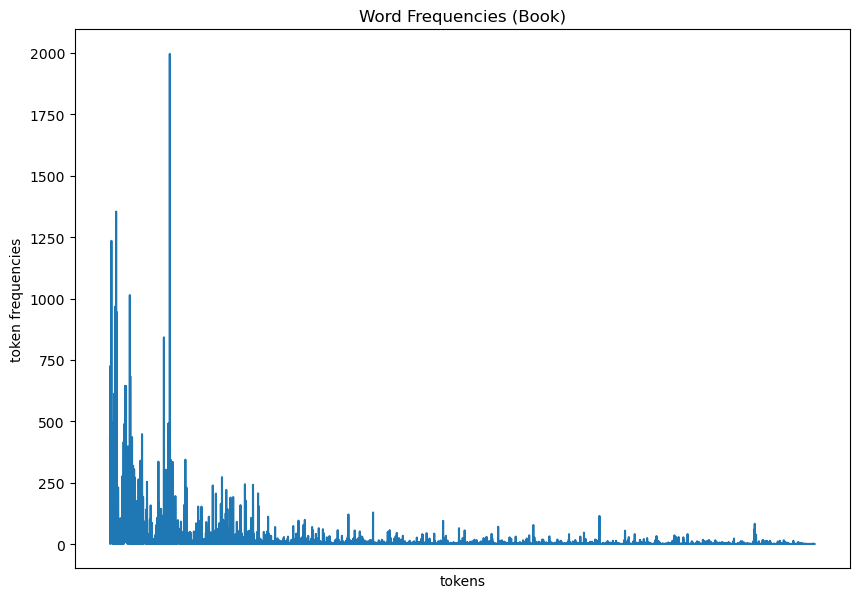


Tokeinzing Data
            tokens  num_tokens  word_length
0    [▁regardless]           1           10
1    [▁gr, ession]           2            8
2      [▁serv, at]           2            6
3    [▁matplotlib]           1           10
4         [▁least]           1            5
..             ...         ...          ...
607   [▁re, gress]           2            7
608        [▁valu]           1            4
609        [▁data]           1            4
610       [▁model]           1            5
611           [▁g]           1            1

[612 rows x 3 columns]
mean:0.31, std:0.20


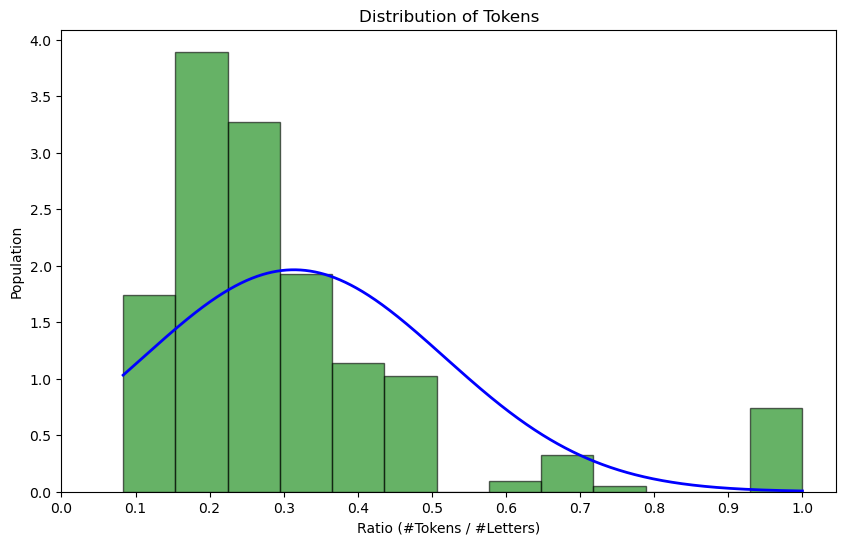

           words
0     activation
1       additive
2     additivity
3    alternative
4     hypothesis
..           ...
753      weights
754       within
755        class
756   covariance
757      wrapper

[758 rows x 1 columns]
[['▁activ'], ['▁add', 'it'], ['▁altern'], ['▁hypoth', 'esi'], ['▁area'], ['▁curv'], ['▁array'], ['▁auc'], ['▁auto'], ['▁correl'], ['▁back', 'fit'], ['▁back', 'ward'], ['▁step', 'w', 'is'], ['▁select'], ['▁bag'], ['▁word'], ['▁bas', 'elin'], ['▁class', 'ifi'], ['▁decis'], ['▁bound', 'ari'], ['▁error'], ['▁re', 'gress'], ['▁tree'], ['▁proced', 'ur'], ['▁subset'], ['▁select'], ['▁b', 'ia'], ['▁b', 'ia'], ['▁var', 'ian', 'c'], ['▁trade'], ['▁b', 'ikes', 'har'], ['▁data'], ['▁set'], ['▁bin', 'ari'], ['▁method'], ['▁boolean'], ['▁bootstrap'], ['▁bottom'], ['▁brain', 'can', 'c'], ['▁data'], ['▁set'], ['▁burn'], ['▁car', 'avan'], ['▁data'], ['▁set'], ['▁car', 'se', 'at'], ['▁data'], ['▁set'], ['▁data'], ['▁left'], ['▁time'], ['▁chain'], ['▁rule'], ['▁c', 'if', 'ar'], ['

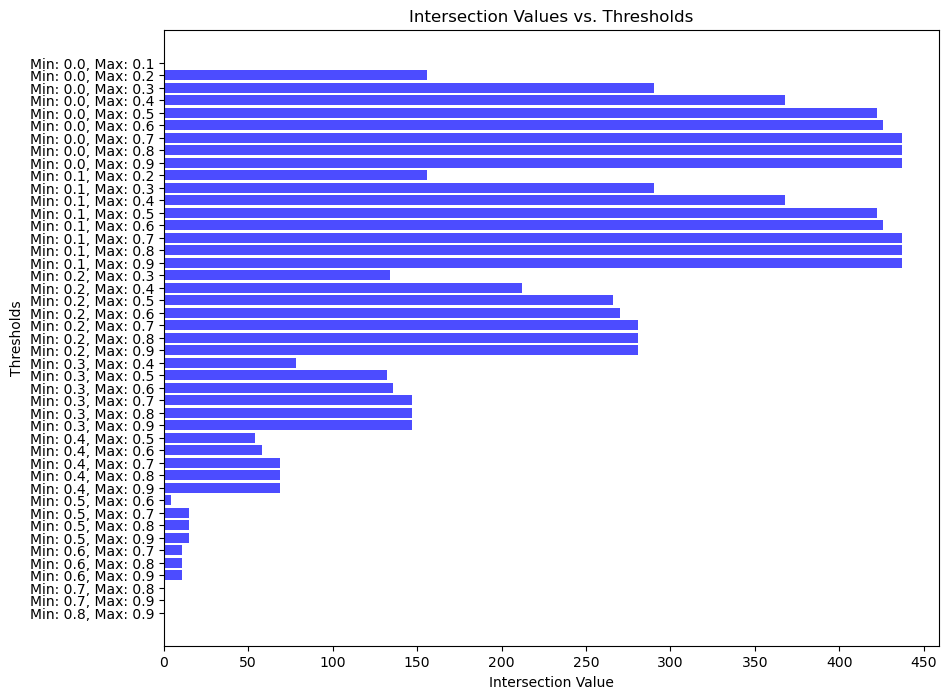

In [278]:
#C:\Users\harri\Downloads\An Introduction to Statistical Learning.pdf
run_console_layer()